In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import re
import warnings
import os
from textblob import TextBlob
import talib
from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
DATA_DIR = "./data"
NEWS_PATH = os.path.join(DATA_DIR, "raw_analyst_ratings.csv")
TICKERS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
INITIAL_CAPITAL = 10000

In [3]:
print("=" * 80)
print("📥 LOADING LOCAL DATA")
print("=" * 80)

📥 LOADING LOCAL DATA


In [4]:
import os
df_news = None
if os.path.exists(NEWS_PATH):
    df = pd.read_csv(NEWS_PATH)
    print(f"✅ News loaded: {len(df)} records")

    # Handle date
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].dt.tz is None:
        df['date'] = df['date'].dt.tz_localize('UTC', ambiguous='infer')
    else:
        df['date'] = df['date'].dt.tz_convert('UTC')
    df = df.dropna(subset=['date'])
    df['date_only'] = df['date'].dt.date
    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")

    # Store
    df_news = df
else:
    print("⚠️ No news file found at:", NEWS_PATH)
    exit()

✅ News loaded: 1407328 records
   Date range: 2011-04-28 01:01:48+00:00 to 2020-06-11 21:12:35+00:00


In [6]:
# ==============================================================================
# 🔍 EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
print("\n" + "=" * 80)
print("📊 EXPLORATORY DATA ANALYSIS (NEWS)")
print("=" * 80)

# ------------------------------------------------------------------------------
# 1. Descriptive Statistics
# ------------------------------------------------------------------------------
print("\n1️⃣ Descriptive Statistics")

# Headline length
df_news['headline'] = df_news['headline'].fillna('')
df_news['headline_len'] = df_news['headline'].str.len()
avg_len = df_news['headline_len'].mean()
print(f"   • Avg headline length: {avg_len:.1f} characters")
print(f"   • Min: {df_news['headline_len'].min()}, Max: {df_news['headline_len'].max()}")

# Publisher stats
if 'publisher' in df_news.columns:
    pub_counts = df_news['publisher'].value_counts()
    print(f"   • Total unique publishers: {pub_counts.shape[0]}")
    print(f"   • Top publisher: {pub_counts.index[0]} ({pub_counts.iloc[0]} articles)")
else:
    print("   ⚠️ No 'publisher' column found.")

# Date trends
daily_counts = df_news.groupby('date_only').size()
print(f"   • Avg articles per day: {daily_counts.mean():.1f}")
print(f"   • Max articles in a day: {daily_counts.max()} on {daily_counts.idxmax()}")


📊 EXPLORATORY DATA ANALYSIS (NEWS)

1️⃣ Descriptive Statistics
   • Avg headline length: 80.0 characters
   • Min: 12, Max: 512
   • Total unique publishers: 225
   • Top publisher: Benzinga Newsdesk (14750 articles)
   • Avg articles per day: 22.4
   • Max articles in a day: 973 on 2020-03-12



2️⃣ Publisher Analysis
   • Top contributing domains:
        Benzinga Newsdesk: 14750
        Lisa Levin: 12408
        ETF Professor: 4362
        Paul Quintaro: 4212
        Benzinga Newsdesk: 3177


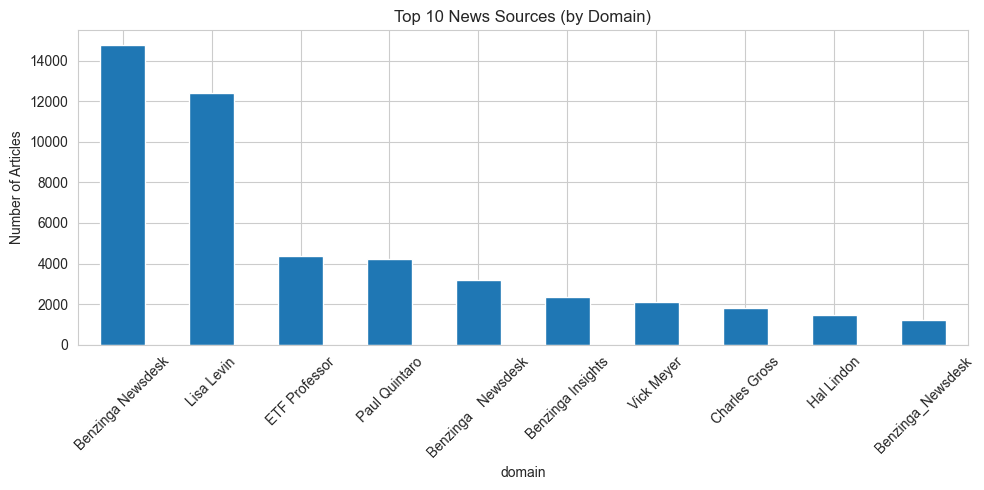

In [7]:
# ------------------------------------------------------------------------------
# 2. Publisher Analysis (with domain extraction if emails)
# ------------------------------------------------------------------------------
print("\n2️⃣ Publisher Analysis")

if 'publisher' in df_news.columns:
    # Extract domain if email-like
    df_news['publisher_clean'] = df_news['publisher'].astype(str)
    if df_news['publisher_clean'].str.contains('@').any():
        df_news['domain'] = df_news['publisher_clean'].str.split('@').str[-1]
        domain_counts = df_news['domain'].value_counts()
        print(f"   • Top contributing domains:")
        for dom, cnt in domain_counts.head(5).items():
            print(f"        {dom}: {cnt}")
    else:
        df_news['domain'] = df_news['publisher_clean']
        domain_counts = df_news['domain'].value_counts()

    # Plot top publishers/domains
    plt.figure(figsize=(10, 5))
    domain_counts.head(10).plot(kind='bar', title="Top 10 News Sources (by Domain)")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("   ⚠️ Skipped: 'publisher' column missing.")


3️⃣ Time Series Analysis


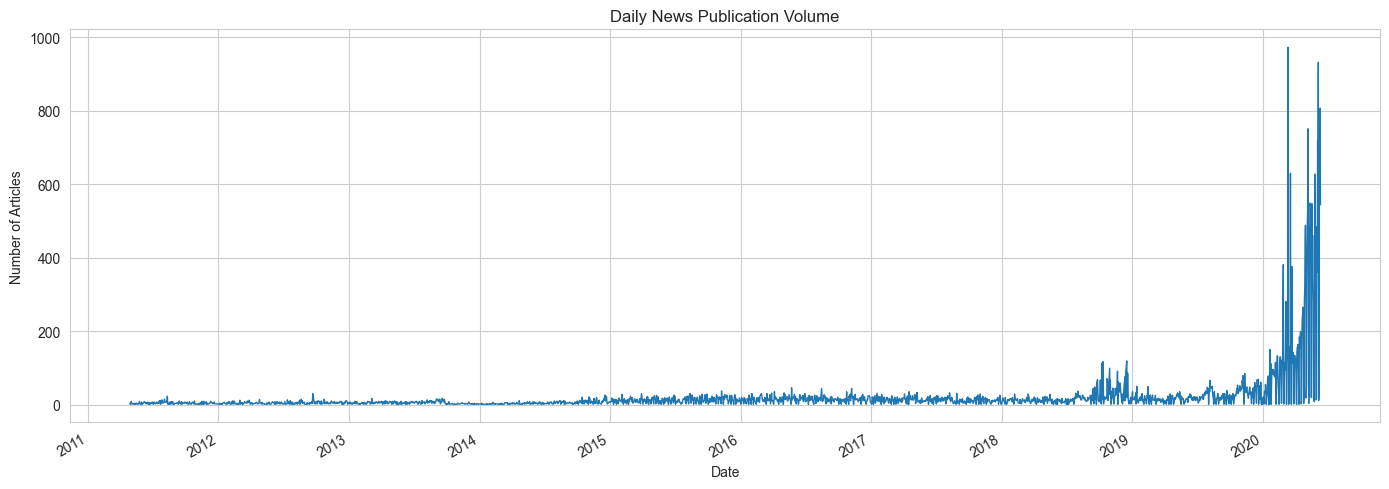

   • Articles by day of week:
        Monday: 10297
        Tuesday: 11037
        Wednesday: 11873
        Thursday: 12712
        Friday: 9407
        Saturday: 273
        Sunday: 388


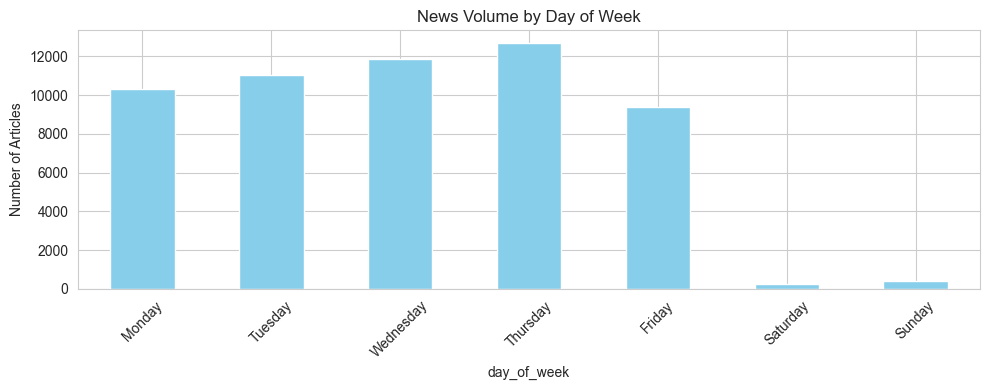


   • Top 5 highest-volume days (possible market events):
        2020-03-12: 973 articles
        2020-06-05: 932 articles
        2020-06-10: 807 articles
        2020-06-09: 803 articles
        2020-06-08: 765 articles


In [8]:
# ------------------------------------------------------------------------------
# 3. Time Series Analysis of News Volume
# ------------------------------------------------------------------------------
print("\n3️⃣ Time Series Analysis")

df_news['date_dt'] = pd.to_datetime(df_news['date_only'])
daily_volume = df_news.groupby('date_dt').size()

# Plot daily news volume
plt.figure(figsize=(14, 5))
daily_volume.plot(linewidth=1)
plt.title("Daily News Publication Volume")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly pattern
df_news['day_of_week'] = df_news['date_dt'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df_news['day_of_week'].value_counts().reindex(dow_order, fill_value=0)
print("   • Articles by day of week:")
for day, cnt in dow_counts.items():
    print(f"        {day}: {cnt}")

plt.figure(figsize=(10, 4))
dow_counts.plot(kind='bar', color='skyblue')
plt.title("News Volume by Day of Week")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify top 5 spike days (potential market events)
spike_days = daily_volume.nlargest(5)
print("\n   • Top 5 highest-volume days (possible market events):")
for date, count in spike_days.items():
    print(f"        {date.date()}: {count} articles")

In [9]:
# ------------------------------------------------------------------------------
# 4. Text & Topic Analysis
# ------------------------------------------------------------------------------
print("\n4️⃣ Text & Topic Analysis")

# Custom keyword function (as before)
def extract_keywords(headlines, n=10):
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of',
                  'with', 'by', 'from', 'as', 'is', 'was', 'are', 'be', 'this', 'that', 'it'}
    words = []
    for h in headlines:
        tokens = re.findall(r'\b[a-z]{3,}\b', str(h).lower())
        words.extend([w for w in tokens if w not in stop_words])
    return Counter(words).most_common(n)

top_words = extract_keywords(df_news['headline'], n=15)
print("   • Top keywords:")
print(", ".join([f"{w}({c})" for w, c in top_words]))

# Bigrams for phrases like "price target", "fda approval"
print("\n   • Top bigrams (2-word phrases):")
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20, min_df=2)
try:
    X = vectorizer.fit_transform(df_news['headline'])
    bigram_freq = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
    top_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]
    for phrase, freq in top_bigrams:
        print(f"        '{phrase}': {int(freq)}")
except ValueError:
    print("        Not enough valid bigrams.")

# Custom event phrase search
event_phrases = ['price target', 'fda approval', 'clinical trial', 'acquisition',
                 'merger', 'lawsuit', 'earnings', 'dividend', 'upgrade', 'downgrade']
print("\n   • Custom event phrase counts:")
for phrase in event_phrases:
    count = df_news['headline'].str.contains(phrase, case=False, na=False).sum()
    if count > 0:
        print(f"        '{phrase}': {count}")

# Sentiment by time/publisher (bonus)
df_news['sentiment'] = df_news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
print(f"\n   • Overall sentiment: mean={df_news['sentiment'].mean():.3f}, std={df_news['sentiment'].std():.3f}")

# Optional: Sentiment by top domain
if 'domain' in df_news.columns:
    top_domains = domain_counts.head(5).index
    sentiment_by_domain = df_news[df_news['domain'].isin(top_domains)].groupby('domain')['sentiment'].mean()
    print("\n   • Avg sentiment by top domain:")
    for dom, sent in sentiment_by_domain.items():
        print(f"        {dom}: {sent:.3f}")



4️⃣ Text & Topic Analysis
   • Top keywords:
stocks(12794), week(9029), shares(8393), trading(6575), hit(5902), eps(5531), market(5482), price(5046), companies(4778), target(4676), several(4650), sales(4429), higher(4271), estimate(3818), lows(3741)

   • Top bigrams (2-word phrases):
        '52 week': 8251
        'stocks hit': 5847
        'hit 52': 5846
        'price target': 4585
        'companies trading': 4082
        'week lows': 3687
        'trading higher': 3517
        'stocks moving': 2841
        'week highs': 2561
        'trading lower': 2152

   • Custom event phrase counts:
        'price target': 4586
        'fda approval': 27
        'clinical trial': 47
        'acquisition': 535
        'merger': 597
        'lawsuit': 30
        'earnings': 2277
        'dividend': 985
        'upgrade': 1495
        'downgrade': 2173

   • Overall sentiment: mean=0.038, std=0.156

   • Avg sentiment by top domain:
        Benzinga Newsdesk: 0.037
        Benzinga Newsdesk: 0